<a href="https://colab.research.google.com/github/ANAVDUTT/iphs290_cultural_analytics_lda_topic_modeling/blob/main/Copy_of_sa_novels_class_20221204.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Jon Chun
24 Oct 2021

# **Requirements**

* Must use **Chrome** browser (esp not Safari)
* Use only **plain text** files (no *.rtf, *.doc, etc)

# **Setup and Configuration**

In [1]:
!nvidia-smi

Mon Dec  5 17:26:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.2 MB/s 
     |████████████████████████████████| 182 kB 54.7 MB/s 
     |████████████████████████████████| 7.6 MB 59.4 MB/s 


In [3]:
!pip install clean-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 2.0 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=d5ba8c1afdcbc0be48fa73cb6e1b6d9e60372dd886beb6ebcf730f4546e84b72
  Stored in directory: /root/.cache/pip/wheels/5e/8c/80/c3646df8201ba6f5070297fe3779a4b70265d0bfd961c15302
Successfully built emoji


In [5]:
!pip install unidecode  # clean-text dependency

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 7.4 MB/s 
     |████████████████████████████████| 110 kB 71.2 MB/s 


In [7]:
!pip install python-slugify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from slugify import slugify

In [9]:
# Python Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re

from cleantext import clean
import contractions
from slugify import slugify

from scipy.signal import find_peaks

from google.colab import files



In [10]:
# Setup matplotlib

# %matplotlib inline

plt.rcParams["figure.figsize"] = (20,10)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Globals

In [11]:
# Global Vars

novel_filename_str = ''
novel_title_str = ''
novel_raw_str = ''
novel_clean_str = ''

novel_lines_ls = []
novel_sentences_ls = []
novel_paragraphs_ls = []

# Main (Modin) DataFrame for Novel Sentiments
sentiment_df = pd.DataFrame

TEXT_ENCODING = 'utf-8'

In [12]:
def verify_novel(anovel_raw_str, anovel_title_str, index_ends=500):
  '''
  INPUT: string in some stage of processing
  OUTPUT: display summary index_ends chars of header/footer for verification
  '''

  print(f'Novel Title: {anovel_title_str}')
  print(f'  Char Len: {len(anovel_raw_str)}')
  print('====================================\n')
  print(f'Beginning:\n\n {anovel_raw_str[:index_ends]}\n\n')
  print('\n------------------------------------')
  print(f'Ending:\n\n {anovel_raw_str[-index_ends:]}\n\n')

In [13]:
def save_text2txt_and_download(text_obj, file_suffix='_save.txt'):
  '''
  INPUT: text object and suffix to add to output text filename
  OUTPUT: Write text object to text file (both temp VM and download)
  '''

  if type(text_obj) == str:
    print('STEP 1. Processing String Object\n')
    str_obj = text_obj
  elif type(text_obj) == list:
    if (len(text_obj) > 0):
      if type(text_obj[0]) == str:
        print('STEP 1. Processing List of Strings Object\n')
        str_obj = "\n".join(text_obj)
      else:
        print('ERROR: Object is not an List of Strings [save_text2txt_and_download()]')
        return -1
    else:
      print('ERROR: Object is an empty List [save_text2txt_and_download()]')
      return -1
  else:
    print('ERROR: Object Type is neither String nor List [save_text2txt_and_download()]')
    return -1

  datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  # out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix
  out_filename = novel_name_str.split('.')[0] + file_suffix

  # Write file to temporary VM filesystem
  print(f'STEP 2. Saving textfile to temporary VM file: {out_filename}\n')
  with open(out_filename, "w") as fp:
    fp.write(str_obj)

  # Download permanent copy of file
  print(f'STEP 3. Downloading permanent copy of textfile: {out_filename}\n')
  files.download(out_filename)

In [14]:
def save_df2csv_and_download(df_obj, file_suffix='_save.csv', nodate=True):
  '''
  INPUT: DataFrame object and suffix to add to output csv filename
  OUTPUT: Write DataFrame object to csv file (both temp VM and download)
  '''

  if isinstance(df_obj, pd.DataFrame):
    datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    if nodate:
      out_filename = novel_name_str.split('.')[0] + file_suffix
    else:
      out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix
    # print(f'STEP 1. Saving DataFrame: {df_obj.__name__} to temporary VM file: {out_filename}\n') # Also, isinstance(obj, pd.DataFrame)
    print(f'STEP 1. Saving DataFrame to temporary VM file: {out_filename}\n')
    df_obj.to_csv(out_filename, index=False) 
  else:
    print(f'ERROR: Object is not a DataFrame [save_df2csv_and_download()]')
    return -1

  # Download permanent copy of file
  print(f'STEP 2. Downloading permanent copy of csvfile: {out_filename}\n')
  files.download(out_filename)


# Test

# save_df2csv_and_download(temp_df, '_bert-nlptown.txt')

In [15]:
def expand_contractions(input_str):
  '''
  INPUT: long string
  OUTPUT: long string with expanded contractions
  '''

  output_str = contractions.fix(input_str)

  return output_str

"""
# novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_ls]
novel_clean_ls = [contractions.fix(x) for x in novel_ls]
novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_clean_ls]
novel_clean_ls = [x.strip() for x in novel_clean_ls if len(x.strip()) > 1]
# novel_clean_ls = [re.sub(r"^[\"\']", "", x) for x in novel_clean_ls]  # re.sub("[\"\']", "", s)
# novel_clean_ls = [re.sub(r"[\"\']$", "", x) for x in novel_clean_ls]
novel_clean_ls = [x.encode('ascii',errors='ignore').decode() for x in novel_clean_ls]
# novel_bin = novel_clean_str.encode('ascii',errors='ignore')
# novel_clean_str = novel_bin.decode()

[f'[{x}]' for x in novel_clean_ls]
"""

'\n# novel_clean_ls = [re.sub(r\'[\n]+\', \' \', x).strip() for x in novel_ls]\nnovel_clean_ls = [contractions.fix(x) for x in novel_ls]\nnovel_clean_ls = [re.sub(r\'[\n]+\', \' \', x).strip() for x in novel_clean_ls]\nnovel_clean_ls = [x.strip() for x in novel_clean_ls if len(x.strip()) > 1]\n# novel_clean_ls = [re.sub(r"^["\']", "", x) for x in novel_clean_ls]  # re.sub("["\']", "", s)\n# novel_clean_ls = [re.sub(r"["\']$", "", x) for x in novel_clean_ls]\nnovel_clean_ls = [x.encode(\'ascii\',errors=\'ignore\').decode() for x in novel_clean_ls]\n# novel_bin = novel_clean_str.encode(\'ascii\',errors=\'ignore\')\n# novel_clean_str = novel_bin.decode()\n\n[f\'[{x}]\' for x in novel_clean_ls]\n'

# **Get the Novel Text**

## OPTION (a): Upload Raw Textfile

In [16]:
%%time

# NOTE: 1m07s

# Upload Plain Text File
uploaded = files.upload()

# NOTE: Allows for multiple file uploads, will only process the last
#       Left in for future feature addition (processing multiple files at once)
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  novel_filename_str = fn

# Extract from Dict and decode binary into char string
novel_raw_str = uploaded[novel_filename_str].decode(TEXT_ENCODING)

KeyboardInterrupt: ignored

In [17]:
#@title Enter Novel_Title in the form [Title] by [Author]

Novel_Title = "The Great Gatsby by F. Scott Fitzgerald" #@param {type:"string"}

# Remove illegal filename punctuation
Novel_Title = Novel_Title.replace("'","")
Novel_Title = Novel_Title.replace('"','')
Novel_Title = Novel_Title.replace('.',' ')

novel_title_str = ' '.join([x.capitalize() for x in slugify(Novel_Title).replace('-',' ').split()])
novel_title_str

'The Great Gatsby By F Scott Fitzgerald'

In [18]:
# CHECK: That you've trimmed the header/footer before uploading

print(f'Novel Filename:\n\n  {novel_filename_str}\n\n')

verify_novel(novel_raw_str, novel_title_str)

Novel Filename:

  


Novel Title: The Great Gatsby By F Scott Fitzgerald
  Char Len: 0

Beginning:

 



------------------------------------
Ending:

 




## OPTION (b): Read from gDrive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive

MessageError: ignored

In [ ]:
# drive.mount("/gdrive", force_remount=True)

In [ ]:
# CUSTOMIZE: set GDrive path below

%cd ./MyDrive/courses/2021f_iphs200_programming_humanity/code/

In [ ]:
!ls *.txt

In [ ]:
# CUSOTMIZE: set 'novel_filename' to the filename of your novel

# novel_filename = 'jkrowling_1sorcerersstone.txt'
novel_filename_str ='Percy_Jackson_The_Lightning_Thief.txt'

In [ ]:
#@title Enter Novel_Title in the form [Title] by [Author]

Novel_Title = "The Lightening Thief by Percy Jackson" #@param {type:"string"}
novel_title_str = Novel_Title

In [ ]:
# Read file into string

with open(novel_filename_str, "r") as fp:
  novel_raw_str = fp.read() #reading all the content in one step

In [ ]:
# Verify

# CHECK: That you've trimmed the header/footer before uploading

print(f'Novel Filename:\n\n  {novel_filename_str}\n\n')

verify_novel(novel_raw_str, novel_title_str)

In [ ]:
# END

In [ ]:
# Read novel into list of Paragraphs

delimiter = "\n\n"

with open(novel_filename, "r") as fp:
  novel_raw_str = fp.read() #reading all the content in one step
  #using the string methods we split it
  novel_parags_ls = novel_raw_str.split(delimiter)
  novel_parags_ls = [x.strip() for x in novel_parags_ls if len(x.strip()) > 2]

print(f'Paragraph Count: {len(novel_parags_ls)}')

In [ ]:
# Read novel into list of Lines

# may need delimiter

with open(novel_filename, 'r') as fp:
  novel_lines_ls = fp.readlines()

print(f'Line Count: {len(novel_lines_ls)}')

In [ ]:
novel_parags_ls[:10]

In [ ]:
novel_ls[100:110]

In [ ]:
# novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_ls]
novel_clean_ls = [contractions.fix(x) for x in novel_ls]
novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_clean_ls]
novel_clean_ls = [x.strip() for x in novel_clean_ls if len(x.strip()) > 1]
# novel_clean_ls = [re.sub(r"^[\"\']", "", x) for x in novel_clean_ls]  # re.sub("[\"\']", "", s)
# novel_clean_ls = [re.sub(r"[\"\']$", "", x) for x in novel_clean_ls]
novel_clean_ls = [x.encode('ascii',errors='ignore').decode() for x in novel_clean_ls]
# novel_bin = novel_clean_str.encode('ascii',errors='ignore')
# novel_clean_str = novel_bin.decode()

[f'[{x}]' for x in novel_clean_ls]

In [ ]:
novel_clean_str = '\n'.join(novel_clean_ls)
print(novel_clean_str[:5000])

In [ ]:
# novel_clean_ls[1] = "THE SILVER SPOON I was born twice: first, as a baby girl, on a remarkably smogless Detroit day in January of 1960; and then again, as a teenage boy, in an emergency room near Petoskey, Michigan, in August of 1974. Specialized readers may have come across me in Dr. Peter Luce’s study, “Gender Identity in 5-Alpha-Reductase Pseudohermaphrodites,” published in theJournal of Pediatric Endocrinology in 1975. Or maybe you’ve seen my photograph in chapter sixteen of the now sadly outdatedGenetics and Heredity."

In [ ]:
# novel_clean_ls.pop(0)

In [ ]:
novel_clean_ls[:10]

In [ ]:
novel_clean_ls[-10:]

In [ ]:
# novel_clean_str = '\n'.join(novel_clean_ls)

# novel_bin = novel_clean_str.encode('ascii',errors='ignore')
# novel_clean_str = novel_bin.decode()

# print(novel_clean_str[:5000])

## OPTION (c): Scrape Project Gutenberg

**Goto *https://gutenberg.net.au* and find the *.HTML (not *.TXT) version of your novel**

In [20]:
from bs4 import BeautifulSoup

import requests

In [21]:
#@title Enter the URL of your novel at ***gutenberg.net.au***
#@markdown Paste the URL to the ***HTML version*** (not plain text).

Novel_Title = 'Frankenstein by Mary Shelley'  #@param {type: "string"}

Gutenberg_URL = 'https://gutenberg.net.au/ebooks/z00006.html'  #@param {type: "string"}


In [22]:
# Get raw HTML of novel from Gutenberg.net.au

response=requests.get(Gutenberg_URL)  # TODO: Pass the URL to the .get() method of the requests object
html = response.text

In [23]:
# View raw HTML that we need to clean up

# TODO: What is the difference between these two outputs?

# Option A: 
html

# Option B:
# print(html)

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN">\n<html>\n<head>\n\n<!-- Google tag (gtag.js) -->\n<script async src="https://www.googletagmanager.com/gtag/js?id=G-ND4S2CL5PN"></script>\n<script>\n  window.dataLayer = window.dataLayer || [];\n  function gtag(){dataLayer.push(arguments);}\n  gtag(\'js\', new Date());\n\n  gtag(\'config\', \'G-ND4S2CL5PN\');\n</script>\n\n\n<!-- Google Tag Manager -->\n<script>(function(w,d,s,l,i){w[l]=w[l]||[];w[l].push({\'gtm.start\':\nnew Date().getTime(),event:\'gtm.js\'});var f=d.getElementsByTagName(s)[0],\nj=d.createElement(s),dl=l!=\'dataLayer\'?\'&l=\'+l:\'\';j.async=true;j.src=\n\'https://www.googletagmanager.com/gtm.js?id=\'+i+dl;f.parentNode.insertBefore(j,f);\n})(window,document,\'script\',\'dataLayer\',\'GTM-KZ4T7VD\');</script>\n<!-- End Google Tag Manager -->\n<meta name="generator" content="HTML-Kit Tools HTML Tidy plugin">\n<title>Frankenstein</title>\n<meta http-equiv="Content-Type" content=\n"text/html; charset=iso-885

In [24]:
# Use HTML <p> to extract text into list of paragraphs

soup = BeautifulSoup(html, "html.parser")


paragraph=soup.find_all("p")  # TODO: get all the <P>Paragraphs</P> 
                                #       see bs4 API ref: https://beautiful-soup-4.readthedocs.io/en/latest/#kinds-of-objects
parag_ls = []
for para in paragraph:
    parag_ls.append(para.text)

print(f'There were {len(parag_ls)} Paragraphs:\n') # TODO how do you get the number of paragraphs in the list parag_ls?

print(f"First 3 Paragraphs: ==============================    \n")
print(f"    {list(print(x) for x in parag_ls[:3])}\n")  # TODO: Give index to retrieve the first 3 paragraphs

print(f"Last 3 Paragraphs: ============================== \n")
print(f"    {list(print(x) for x in parag_ls[-3:])}\n")  # TODO: Give index to retrieve the last 3 paragraphs


There were 657 Paragraphs:

First 3 Paragraphs: ==============================    

 
St. Petersburgh, Dec. 11th, 17—
To Mrs. Saville, England
    [None, None, None]

Last 3 Paragraphs: ============================== 

He sprang from the cabin window as he said this, upon the ice
raft which lay close to the vessel. He was soon borne away by the
waves and lost in darkness and distance.
 
This site is full of FREE ebooks - Project Gutenberg Australia
    [None, None, None]



In [25]:
# Concatenate all paragraphs into a single novel string

# For every paragraph, replace all hardcoded \r\n with a single space
parag_flat_ls = [re.sub(r'\r\n', ' ', aparag) for aparag in parag_ls]

# Concatenate all paragraphs into a single string, separated by two \n
novel_raw_str = '\n\n'.join(parag_flat_ls)

print('\nSTART OF NOVEL: -----')
print(novel_raw_str[:1000] + '\n')

print('\nEND OF NOVEL: -----\n')
print(novel_raw_str[-1000:])


START OF NOVEL: -----
 

St. Petersburgh, Dec. 11th, 17—

To Mrs. Saville, England

You will rejoice to hear that no disaster has accompanied the
commencement of an enterprise which you have regarded with such
evil forebodings. I arrived here yesterday, and my first task is to
assure my dear sister of my welfare and increasing confidence in
the success of my undertaking.

I am already far north of London, and as I walk in the streets
of Petersburgh, I feel a cold northern breeze play upon my cheeks,
which braces my nerves and fills me with delight. Do you understand
this feeling? This breeze, which has travelled from the regions
towards which I am advancing, gives me a foretaste of those icy
climes. Inspirited by this wind of promise, my daydreams become
more fervent and vivid. I try in vain to be persuaded that the pole
is the seat of frost and desolation; it ever presents itself to my
imagination as the region of beauty and delight. There, Margaret,
the sun is forever visible, its b

**Enter the First and Last several words to use as RegEx for trimming header/footers**

In [26]:
#@title Enter the first sentence in the body of your novel
sentence_first_str = 'St. Petersburgh, Dec. 11th'  #@param {type: "string"}




In [27]:
#@title Enter the last sentence in the body of your novel
sentence_last_str = 'waves and lost in darkness and distance.'  #@param {type: "string"}

In [28]:
# Strip off the header
# novel_clean = ' '.join(novel_str.partition(sentence_first_str)[1:])

# Strip off the footer
# ' '.join(novel_clean.partition(sentence_last_str)[:2])[-500:]

In [29]:
# Strip off the header
novel_raw_str = ' '.join(novel_raw_str.partition(sentence_first_str)[1:])

# Strip off the footer
novel_raw_str = ' '.join(novel_raw_str.partition(sentence_last_str)[:2])

# Verify

print('\nSTART OF CLEAN NOVEL: -----')
print(novel_raw_str[:1000] + '\n')

print('\nEND OF CLEAN NOVEL: -----\n')
print(novel_raw_str[-1000:])


START OF CLEAN NOVEL: -----
St. Petersburgh, Dec. 11th , 17—

To Mrs. Saville, England

You will rejoice to hear that no disaster has accompanied the
commencement of an enterprise which you have regarded with such
evil forebodings. I arrived here yesterday, and my first task is to
assure my dear sister of my welfare and increasing confidence in
the success of my undertaking.

I am already far north of London, and as I walk in the streets
of Petersburgh, I feel a cold northern breeze play upon my cheeks,
which braces my nerves and fills me with delight. Do you understand
this feeling? This breeze, which has travelled from the regions
towards which I am advancing, gives me a foretaste of those icy
climes. Inspirited by this wind of promise, my daydreams become
more fervent and vivid. I try in vain to be persuaded that the pole
is the seat of frost and desolation; it ever presents itself to my
imagination as the region of beauty and delight. There, Margaret,
the sun is forever visible, i

In [30]:
# END

In [31]:
# CUSTOMIZE: Set delimiter to one (\n) or two (\n\n) returns

# Read novel into list of Paragraphs

delimiter = "\n\n" # or "\n"

novel_paragraphs_ls = novel_raw_str.split(delimiter)
novel_paragraphs_ls = [x.strip() for x in novel_paragraphs_ls if len(x.strip()) > 2]
novel_paragraphs_ls = [' '.join(x.split()) for x in novel_paragraphs_ls]

print(f'Paragraph Count: {len(novel_paragraphs_ls)}')

Paragraph Count: 653


In [32]:
# Verify you have list of paragraphs, not sentences

novel_paragraphs_ls[:15]

['St. Petersburgh, Dec. 11th , 17—',
 'To Mrs. Saville, England',
 'You will rejoice to hear that no disaster has accompanied the commencement of an enterprise which you have regarded with such evil forebodings. I arrived here yesterday, and my first task is to assure my dear sister of my welfare and increasing confidence in the success of my undertaking.',
 'I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. Do you understand this feeling? This breeze, which has travelled from the regions towards which I am advancing, gives me a foretaste of those icy climes. Inspirited by this wind of promise, my daydreams become more fervent and vivid. I try in vain to be persuaded that the pole is the seat of frost and desolation; it ever presents itself to my imagination as the region of beauty and delight. There, Margaret, the sun is forever visible, its broad disk just

In [33]:
for i,aline in enumerate(novel_paragraphs_ls):
  if (len(aline.strip()) < 5):
    print(f'Line #{i}: {aline}')

Line #24: R.W.


In [34]:
novel_clean_str = '\n'.join(novel_parags_ls)
novel_clean_str[:2000]

NameError: ignored

# **Split Novel into Sentences**

* https://github.com/zaemyung/sentsplit (CRF: mincut)

* https://github.com/adobe/NLP-Cube and Rank ~15 https://aclanthology.org/K18-2017.pdf

In [35]:
import nltk

nltk.download('punkt')

from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [36]:
novel_sentences_ls = sent_tokenize(novel_raw_str)

sent_ct = len(novel_sentences_ls)
sent_show = 10

print('\nFirst Sentences: -----\n')
# for i, asent in enumerate(novel_sentences_ls[:sent_show]):
for i, asent in enumerate(novel_sentences_ls[:sent_show]):
  print(f'Sentences #{i}: {asent}')


print('\nLast Sentences: -----\n')
for i, asent in enumerate(novel_sentences_ls[-sent_show:]):
  print(f'Sentences #{sent_ct - (sent_show - i)}: {asent}')


print(f'\n\nThere are {sent_ct} Sentences in the novel')


First Sentences: -----

Sentences #0: St. Petersburgh, Dec. 11th , 17—

To Mrs. Saville, England

You will rejoice to hear that no disaster has accompanied the
commencement of an enterprise which you have regarded with such
evil forebodings.
Sentences #1: I arrived here yesterday, and my first task is to
assure my dear sister of my welfare and increasing confidence in
the success of my undertaking.
Sentences #2: I am already far north of London, and as I walk in the streets
of Petersburgh, I feel a cold northern breeze play upon my cheeks,
which braces my nerves and fills me with delight.
Sentences #3: Do you understand
this feeling?
Sentences #4: This breeze, which has travelled from the regions
towards which I am advancing, gives me a foretaste of those icy
climes.
Sentences #5: Inspirited by this wind of promise, my daydreams become
more fervent and vivid.
Sentences #6: I try in vain to be persuaded that the pole
is the seat of frost and desolation; it ever presents itself to my
im

In [37]:
# Delete the empty Sentences and those without any alphabetic characters

novel_sentences_ls = [x.strip() for x in novel_sentences_ls if len(x.strip()) > 0]
novel_sentences_ls = [x.strip() for x in novel_sentences_ls if re.search('[a-zA-Z]', x)]
len(novel_sentences_ls)

3171

In [38]:
# View the shortest Setences

sorted(novel_sentences_ls, key=len)[:100]
# type(min(novel_sentences_ls, key=len))
# novel_sentences_ls[:1000]

['Oh!',
 'No!',
 'No!',
 'Ah!',
 'Oh!',
 'Oh!',
 'Ah!',
 'Ah!',
 'Oh!',
 'Oh!',
 'Oh!',
 'Oh!',
 'Oh!',
 'Oh!',
 'Oh!',
 'R.W.',
 '"Ah!',
 'Man!',
 '"Oh!',
 'Alas!',
 'Alas!',
 'Alas!',
 'Alas!',
 'Alas!',
 'Alas!',
 'Alas!',
 'Alas!',
 'Alas!',
 'Alas!',
 'Alas!',
 'Alas!',
 '"Yes."',
 '"Alas!',
 '"Alas!',
 '"Alas!',
 '"Alas!"',
 'Begone!',
 'Begone!',
 'Begone!',
 'Oh,\nno!',
 'I said.',
 'Despair!',
 'And, oh!',
 '"Begone!',
 'He came.',
 'Clerval!',
 '"Begone!',
 'said he.',
 'Good God!',
 'Good God!',
 'Save me!"',
 'Good God!',
 'She wept.',
 'said she.',
 'said she.',
 'said\nshe.',
 '"Wretch!"',
 'Beautiful!',
 'Great God!',
 'Who was I?',
 "'Come in.'",
 '"I paused.',
 'Oh, earth!',
 'Let me go.',
 'I replied.',
 'Great God!',
 'Great God!',
 'Great God!',
 '"Farewell!',
 'Farewell."',
 'I trembled.',
 'What\nwas I?',
 'What was I?',
 '"I knocked.',
 '"I entered.',
 'We sat late.',
 'Oh, save me!',
 'One subject!',
 'Do not fear.',
 'But\nhear me.',
 'Ugly\nwretch!',
 'I was m

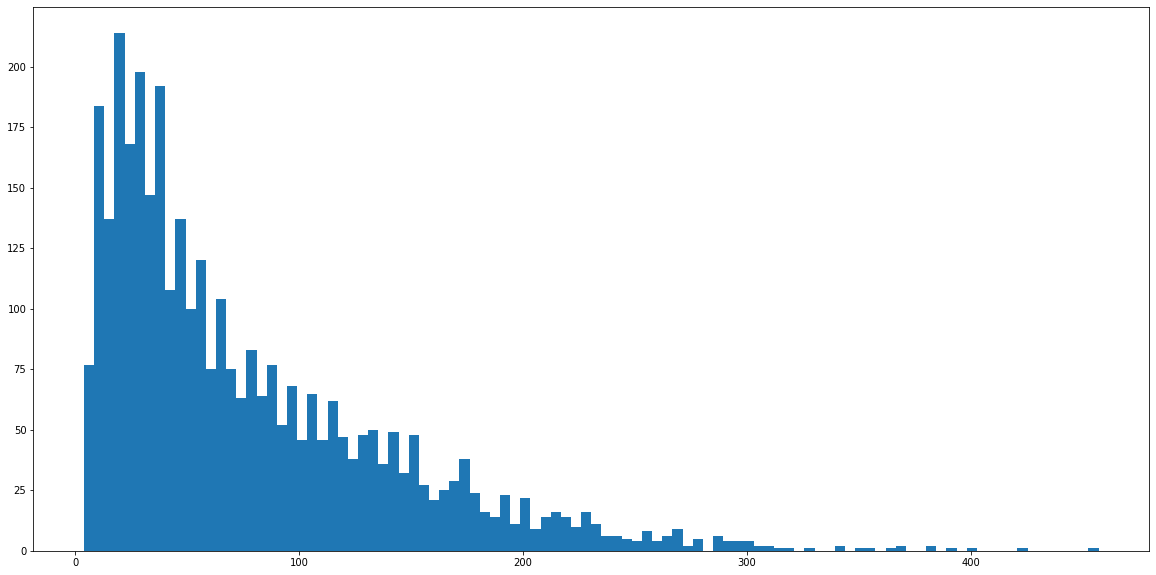

In [ ]:

# View distribution of sentence lengths

_ = plt.hist([len(x) for x in novel_sentences_ls], bins=100)

# **Clean and Slice Strings**

In [ ]:
def clean_str(dirty_str):
  '''
  INPUT: a raw string
  OUTPUT: a clean string
  '''

  contraction_expanded_str = contractions.fix(dirty_str)

  clean_str = clean(contraction_expanded_str,
      fix_unicode=True,               # fix various unicode errors
      to_ascii=True,                  # transliterate to closest ASCII representation
      lower=True,                     # lowercase text
      no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
      no_urls=False,                  # replace all URLs with a special token
      no_emails=False,                # replace all email addresses with a special token
      no_phone_numbers=False,         # replace all phone numbers with a special token
      no_numbers=False,               # replace all numbers with a special token
      no_digits=False,                # replace all digits with a special token
      no_currency_symbols=False,      # replace all currency symbols with a special token
      no_punct=False,                 # remove punctuations
      # replace_with_punct="",          # instead of removing punctuations you may replace them
      # replace_with_url="<URL>",
      # replace_with_email="<EMAIL>",
      # replace_with_phone_number="<PHONE>",
      # replace_with_number="<NUMBER>",
      # replace_with_digit="0",
      # replace_with_currency_symbol="<CUR>",
      lang="en"                       # set to 'de' for German special handling
  )

  # Replace all new lines/returns with single whitespace
  clean_str = ' '.join(clean_str.split())
  # clean_str = clean_str.replace('\n\r', ' ')
  # clean_str = clean_str.replace('\n', ' ')
  # clean_str = clean_str.replace('\r', ' ')
  # clean_str = ' '.join(clean_str.split())

  # Strip unpaired leading/trailing quotes
  if (clean_str.count('"') % 2 == 1):
    clean_str = clean_str.strip('"')
  if (clean_str.count("'") % 2 == 1):
    clean_str = clean_str.strip("'")

  return clean_str 

# Test

clean_str("This \n\n\n is a very dirty DIRTY StrInG!!")
clean_str('"up!')
clean_str('"Watch out!" he said.')

'this is a very dirty dirty string!!'

'up!'

'"watch out!" he said.'

In [ ]:
# Verify

# verify_novel(novel_clean_str, index_ends=500)

In [ ]:
# Create sentiment_df to hold text sentences and corresponding sentiment values

sentiment_df = pd.DataFrame({'text_raw': novel_sentences_ls})
sentiment_df['text_raw'] = sentiment_df['text_raw'].astype('string')
sentiment_df['text_raw'] = sentiment_df['text_raw'].str.strip()

sentiment_df.head()
sentiment_df.info()

,text_raw
0,Chapter 1 In my younger and more vulner...
1,"""Whenever you feel like criticizing any one,"" ..."
2,He didn't say any more but we've always been u...
3,In consequence I'm inclined to reserve all jud...
4,The abnormal mind is quick to detect and atta...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3443 entries, 0 to 3442
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text_raw  3443 non-null   string
dtypes: string(1)
memory usage: 27.0 KB


In [ ]:
# clean the 'text_raw' column and create the 'text_clean' column

# novel_df['text_clean'] = hero.clean(novel_df['text_raw'])
sentiment_df['text_clean'] = sentiment_df['text_raw'].apply(lambda x: clean_str(x))
sentiment_df['text_clean'] = sentiment_df['text_clean'].astype('string')
sentiment_df['text_raw_len'] = sentiment_df['text_raw'].apply(lambda x: len(x))

sentiment_df.head()
sentiment_df.info()

,text_raw,text_clean,text_raw_len
0,Chapter 1 In my younger and more vulner...,chapter 1 in my younger and more vulnerable ye...,138
1,"""Whenever you feel like criticizing any one,"" ...","""whenever you feel like criticizing any one,"" ...",153
2,He didn't say any more but we've always been u...,he did not say any more but we have always bee...,149
3,In consequence I'm inclined to reserve all jud...,in consequence i am inclined to reserve all ju...,165
4,The abnormal mind is quick to detect and atta...,the abnormal mind is quick to detect and attac...,256


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3443 entries, 0 to 3442
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text_raw      3443 non-null   string
 1   text_clean    3443 non-null   string
 2   text_raw_len  3443 non-null   int64 
dtypes: int64(1), string(2)
memory usage: 80.8 KB


In [ ]:
# Drop Sentence if Raw length < 1 (Double check)

# sentiment_df = sentiment_df[sentiment_df['text_raw_len'] > 0]

print(f"\n\nThere are {sentiment_df['text_raw'].isna().sum()} BLANK [text_raw] lines")

print(f"There are {sentiment_df['text_clean'].isna().sum()} BLANK [text_clean] lines")

sentiment_df.shape



There are 0 BLANK [text_raw] lines
There are 0 BLANK [text_clean] lines


(3443, 3)

In [ ]:
sentiment_df.sort_values(by=['text_raw_len']).head(20)

,text_raw,text_clean,text_raw_len
2090,"""Mr.",mr.,4
2053,Hot!,hot!,4
2054,Hot!,hot!,4
2052,Hot!,hot!,4
2571,God!,god!,4
2607,"""No .",no .,5
1240,"""Oh!""","""oh!""",5
2192,"""Oh.""","""oh.""",5
1219,"""No?""","""no?""",5
3402,"""Yes.",yes.,5


# **Sentiment Analysis**

## **VADER**

In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 30.7 MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vader_sa = SentimentIntensityAnalyzer()

In [ ]:
vader_sa.polarity_scores('I love lint')['compound']

0.6369

In [ ]:
sentiment_df['vader'] = sentiment_df['text_clean'].apply(lambda x : vader_sa.polarity_scores(x)['compound'])
sentiment_df.head(10)

,text_raw,text_clean,text_raw_len,vader
0,Chapter 1 In my younger and more vulner...,chapter 1 in my younger and more vulnerable ye...,138,-0.2944
1,"""Whenever you feel like criticizing any one,"" ...","""whenever you feel like criticizing any one,"" ...",153,-0.2755
2,He didn't say any more but we've always been u...,he did not say any more but we have always bee...,149,0.7684
3,In consequence I'm inclined to reserve all jud...,in consequence i am inclined to reserve all ju...,165,-0.2732
4,The abnormal mind is quick to detect and atta...,the abnormal mind is quick to detect and attac...,256,-0.2960
5,Most of the confidences were unsought--freque...,most of the confidences were unsought--frequen...,363,-0.3818
6,Reserving judgments is a matter of infinite h...,reserving judgments is a matter of infinite hope.,50,0.4588
7,I am still a little afraid of missing somethi...,i am still a little afraid of missing somethin...,202,-0.7380
8,"And, after boasting this way of my tolerance, ...","and, after boasting this way of my tolerance, ...",91,0.2960
9,Conduct may be founded on the hard rock or the...,conduct may be founded on the hard rock or the...,120,-0.2481


## **TextBlob**

In [ ]:
from textblob import TextBlob

In [ ]:
testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!")
print(testimonial.sentiment.polarity)

0.39166666666666666


In [ ]:
sentiment_df['textblob'] = sentiment_df['text_clean'].apply(lambda x : TextBlob(x).sentiment.polarity)
sentiment_df.head(10)

,text_raw,text_clean,text_raw_len,vader,textblob
0,Chapter 1 In my younger and more vulner...,chapter 1 in my younger and more vulnerable ye...,138,-0.2944,0.000000
1,"""Whenever you feel like criticizing any one,"" ...","""whenever you feel like criticizing any one,"" ...",153,-0.2755,0.000000
2,He didn't say any more but we've always been u...,he did not say any more but we have always bee...,149,0.7684,0.500000
3,In consequence I'm inclined to reserve all jud...,in consequence i am inclined to reserve all ju...,165,-0.2732,0.085000
4,The abnormal mind is quick to detect and atta...,the abnormal mind is quick to detect and attac...,256,-0.2960,0.016667
5,Most of the confidences were unsought--freque...,most of the confidences were unsought--frequen...,363,-0.3818,0.064286
6,Reserving judgments is a matter of infinite h...,reserving judgments is a matter of infinite hope.,50,0.4588,0.000000
7,I am still a little afraid of missing somethi...,i am still a little afraid of missing somethin...,202,-0.7380,-0.329167
8,"And, after boasting this way of my tolerance, ...","and, after boasting this way of my tolerance, ...",91,0.2960,0.000000
9,Conduct may be founded on the hard rock or the...,conduct may be founded on the hard rock or the...,120,-0.2481,-0.059127


## **DistilBERT**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

In [ ]:
# Load tokenizer and model, create trainer

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# Create class for data preparation

class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

In [ ]:
%%time

# Test: text_sentiment_dt['cdickins_achristmascarol']['text_clean']

# NOTE:  1m38s 14:00EST on 01 Nov 2022 Colab Pro (The Great Gatsby)
#        1m39s 17:05EST on 01 Nov 2022 Colab Pro (The Great Gatsby)

# Compute sentiment time series

def get_distilbert_sentiment(text_clean_ls, sample_size=10):
  # text_clean_ls = text_sentiment_dt['cdickins_achristmascarol']['text_clean'].to_list()
  # text_clean_ls = text_sentiment_dt['cdickins_achristmascarol']['text_clean'].to_list()

  # Tokenize texts and create prediction data set
  tokenized_texts = tokenizer(text_clean_ls,truncation=True,padding=True)
  pred_dataset = SimpleDataset(tokenized_texts)

  # Run predictions
  predictions = trainer.predict(pred_dataset)

  # Transform predictions to labels
  sentiment_ls = predictions.predictions.argmax(-1)
  label_ls = pd.Series(sentiment_ls).map(model.config.id2label)
  score_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

  # Create DataFrame with texts, predictions, labels, and scores
  # line_no_ls = list(range(len(sentiment_ls)))
  # distilbert_df = pd.DataFrame(list(zip(line_no_ls, text_clean_ls,sentiment_ls,label_ls,score_ls)), columns=['line_no','line','sentiment','label','score'])
  # distilbert_df.head()

  # Adjust for POS/NEG sign
  label_score_ls = list(zip(label_ls,score_ls))
  sentiment_signed_ls = [ascore if alabel.lower().strip()=='positive' else (-1.0*ascore) for alabel, ascore in label_score_ls] 

  # print(f'label_ls:\n  {label_ls[:sample_size]}')
  # print(f'score_ls:\n {score_ls[:sample_size]}')

  return sentiment_signed_ls, label_ls

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.34 µs


In [ ]:
# Test

line_ls = ['I like that','That is annoying','This is great!','Wouldn´t recommend it.']
sentiment_signed_ls, label_ls = get_distilbert_sentiment(line_ls)

print(f'sentiment_signed_ls:\n  {sentiment_signed_ls}')
print(f'label_ls:\n  {label_ls}')

***** Running Prediction *****
  Num examples = 4
  Batch size = 8


sentiment_signed_ls:
  [0.9998562, -0.9997524619102478, 0.9998695, 0.9502347]
label_ls:
  0    POSITIVE
1    NEGATIVE
2    POSITIVE
3    POSITIVE
dtype: object


In [ ]:
%%time

# NOTE: ~20m

text_clean_ls = sentiment_df['text_clean'].to_list()
sentiment_ls, label_ls = get_distilbert_sentiment(text_clean_ls)

sentiment_df['distilbert'] = sentiment_ls
sentiment_df.head()
sentiment_df.info()

***** Running Prediction *****
  Num examples = 3443
  Batch size = 8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3443 entries, 0 to 3442
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   text_raw      3443 non-null   string 
 1   text_clean    3443 non-null   string 
 2   text_raw_len  3443 non-null   int64  
 3   vader         3443 non-null   float64
 4   textblob      3443 non-null   float64
 5   distilbert    3443 non-null   float64
dtypes: float64(3), int64(1), string(2)
memory usage: 161.5 KB
CPU times: user 7.93 s, sys: 73.5 ms, total: 8 s
Wall time: 14.6 s


In [ ]:
sentiment_df.head()

,text_raw,text_clean,text_raw_len,vader,textblob,distilbert
0,Chapter 1 In my younger and more vulner...,chapter 1 in my younger and more vulnerable ye...,138,-0.2944,0.000000,0.976513
1,"""Whenever you feel like criticizing any one,"" ...","""whenever you feel like criticizing any one,"" ...",153,-0.2755,0.000000,-0.998295
2,He didn't say any more but we've always been u...,he did not say any more but we have always bee...,149,0.7684,0.500000,0.993674
3,In consequence I'm inclined to reserve all jud...,in consequence i am inclined to reserve all ju...,165,-0.2732,0.085000,0.764931
4,The abnormal mind is quick to detect and atta...,the abnormal mind is quick to detect and attac...,256,-0.2960,0.016667,-0.988105


In [ ]:
%whos str

Variable             Type    Data/Info
--------------------------------------
Novel_Title          str     The Great Gatsby by F  Scott Fitzgerald
TEXT_ENCODING        str     utf-8
\nthe past.
fn                   str     TheGreatGatsby_FScottFitzgerald.txt
model_name           str     distilbert-base-uncased-finetuned-sst-2-english
novel_clean_str      str     
novel_filename_str   str     TheGreatGatsby_FScottFitzgerald.txt
\n
novel_title_str      str     The Great Gatsby By F Scott Fitzgerald


In [ ]:
slugify(Novel_Title)

'the-great-gatsby-by-f-scott-fitzgerald'

In [ ]:
"".join(novel_filename_str.split('.')[:-1]).lower()

'thegreatgatsby_fscottfitzgerald'

In [ ]:
filename_sentiment = f"novel_sentiment_{slugify(''.join(novel_filename_str.split('.')[:-1]).lower(), separator='_')}.csv"
sentiment_df.to_csv(filename_sentiment)

print(f'\n\n     >>>>> SAVED PLOT TO FILE: [{filename_sentiment}] <<<<<')



     >>>>> SAVED PLOT TO FILE: [novel_sentiment_thegreatgatsby_fscottfitzgerald.csv] <<<<<


In [ ]:
files.download(filename_sentiment)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Plot Sentiment**

In [ ]:
sentiment_df.insert(0, 'SeqNo', list(range(0, sentiment_df.shape[0])))

In [ ]:
sentiment_df.head()

,SeqNo,text_raw,text_clean,text_raw_len,vader,textblob,distilbert,vader_sma10,textblob_sma10,distilbert_sma10,vader_stdscaler,textblob_stdscaler,distilbert_stdscaler
0,0,Chapter 1 In my younger and more vulner...,chapter 1 in my younger and more vulnerable ye...,138,-0.2944,0.000000,0.976513,0.068924,0.060351,0.005477,1.026399,1.540573,0.947824
1,1,"""Whenever you feel like criticizing any one,"" ...","""whenever you feel like criticizing any one,"" ...",153,-0.2755,0.000000,-0.998295,0.070105,0.060652,0.000002,1.064902,1.557364,0.898279
2,2,He didn't say any more but we've always been u...,he did not say any more but we have always bee...,149,0.7684,0.500000,0.993674,0.074619,0.062411,0.005741,1.212087,1.655329,0.950213
3,3,In consequence I'm inclined to reserve all jud...,in consequence i am inclined to reserve all ju...,165,-0.2732,0.085000,0.764931,0.075209,0.061072,0.000008,1.231331,1.580755,0.898330
4,4,The abnormal mind is quick to detect and atta...,the abnormal mind is quick to detect and attac...,256,-0.2960,0.016667,-0.988105,0.070360,0.059305,-0.005503,1.073200,1.482302,0.848466


In [ ]:
from sklearn.preprocessing import StandardScaler

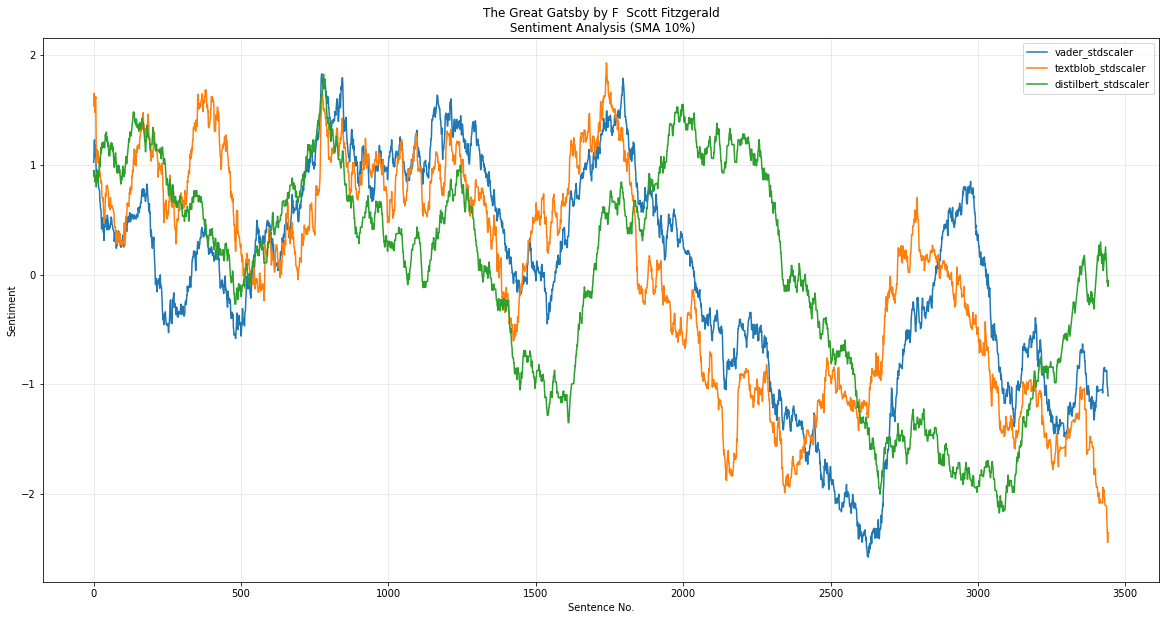

In [ ]:
#@title Enter the Sliding Window width as Percent of Novel length (default 10%, larger=smoother)

plt.rcParams['figure.figsize'] = [20, 10]

window_percent = 10 #@param {type:"slider", min:1, max:20, step:1}

win_per = int(window_percent/100 * sentiment_df.shape[0])

vader_col = f'vader_sma{window_percent}'
sentiment_df[vader_col] = sentiment_df['vader'].rolling(win_per, center=True, min_periods=1).mean()

textblob_col = f'textblob_sma{window_percent}'
sentiment_df[textblob_col] = sentiment_df['textblob'].rolling(win_per, center=True, min_periods=1).mean()

distilbert_col = f'distilbert_sma{window_percent}'
sentiment_df[distilbert_col] = sentiment_df['distilbert'].rolling(win_per, center=True, min_periods=1).mean()

# Normalize Time Series to same y-range
sentiment_model_ls = [vader_col, textblob_col, distilbert_col]
sentiment_model_norm_ls = ['vader_stdscaler',
                           'textblob_stdscaler',
                           'distilbert_stdscaler']

sentiment_df[sentiment_model_norm_ls] = StandardScaler().fit_transform(sentiment_df[sentiment_model_ls])

sentiment_df.plot(y=sentiment_model_norm_ls, x='SeqNo')

plt.title(f'{Novel_Title}\n Sentiment Analysis (SMA {window_percent}%)')
plt.ylabel('Sentiment')
plt.xlabel('Sentence No.')
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.show();

In [ ]:
sentiment_df.head()

,SeqNo,text_raw,text_clean,text_raw_len,vader,textblob,distilbert,vader_sma10,textblob_sma10,distilbert_sma10,vader_stdscaler,textblob_stdscaler,distilbert_stdscaler
0,0,Chapter 1 In my younger and more vulner...,chapter 1 in my younger and more vulnerable ye...,138,-0.2944,0.000000,0.976513,0.068924,0.060351,0.005477,1.026399,1.540573,0.947824
1,1,"""Whenever you feel like criticizing any one,"" ...","""whenever you feel like criticizing any one,"" ...",153,-0.2755,0.000000,-0.998295,0.070105,0.060652,0.000002,1.064902,1.557364,0.898279
2,2,He didn't say any more but we've always been u...,he did not say any more but we have always bee...,149,0.7684,0.500000,0.993674,0.074619,0.062411,0.005741,1.212087,1.655329,0.950213
3,3,In consequence I'm inclined to reserve all jud...,in consequence i am inclined to reserve all ju...,165,-0.2732,0.085000,0.764931,0.075209,0.061072,0.000008,1.231331,1.580755,0.898330
4,4,The abnormal mind is quick to detect and atta...,the abnormal mind is quick to detect and attac...,256,-0.2960,0.016667,-0.988105,0.070360,0.059305,-0.005503,1.073200,1.482302,0.848466


# **Crux Detection**

In [ ]:
#@title Which Lexicon?

Sentiment_Model = "VADER" #@param ["VADER", "TextBlob", "DistilBERT"]

<ipython-input-75-23372351519c>:29: PeakPropertyWarning: some peaks have a width of 0
  peaks3, _ = find_peaks(x, width=width_min)


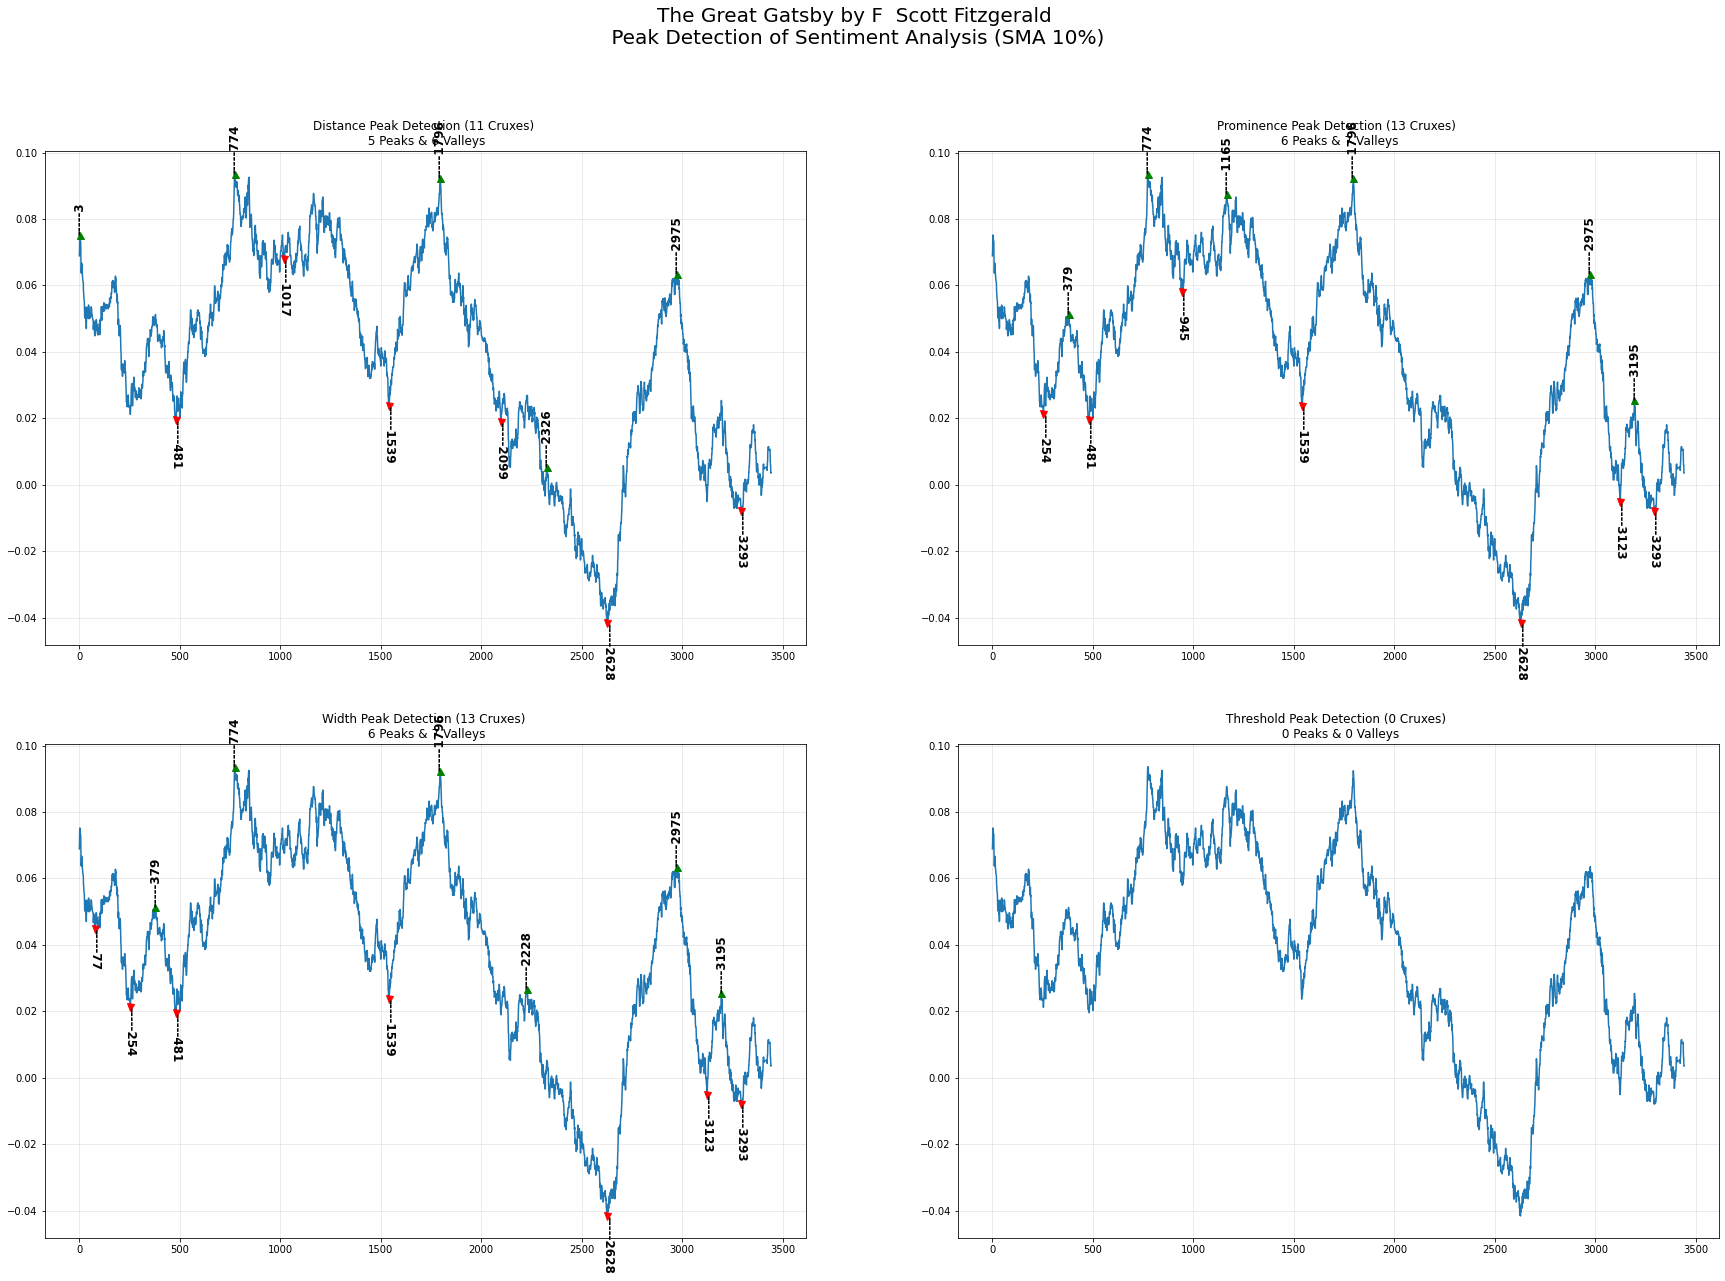

In [ ]:
#@title Tune the main Hyperparameter for each of the 4 Peak Detection Algorithms:

Distance_Min = 520 #@param {type:"slider", min:100, max:1000, step:10}
Prominence_Min = 0.022 #@param {type:"slider", min:0.001, max:0.05, step:0.001}
Width_Min = 60 #@param {type:"slider", min:25, max:500, step:5}
Threshold_Min = 0.005 #@param {type:"slider", min:0.001, max:0.01, step:0.001}

plt.rcParams['figure.figsize'] = [30, 20]

model_name = f'{Sentiment_Model.lower()}_sma{window_percent}'

x = sentiment_df[model_name]

# Peak Algo #1 (by Distance)
distance_min = Distance_Min # 750

# Peak Algo #2 (by Prominence)
prominence_min = Prominence_Min # 0.01

# Peak Algo #3 (by Width)
width_min = Width_Min # 175

# Peak Algo #4 (by Threshold)
threshold_min = Threshold_Min # 0.001


peaks, _ = find_peaks(x, distance=distance_min)
peaks2, _ = find_peaks(x, prominence=prominence_min)      # BEST!
peaks3, _ = find_peaks(x, width=width_min)
peaks4, _ = find_peaks(x, threshold=threshold_min)     # Required vertical distance to its direct neighbouring samples, pretty useless


x_inv = pd.Series([-x for x in sentiment_df[model_name].to_list()])

valleys, _ = find_peaks(x_inv, distance=distance_min)
valleys2, _ = find_peaks(x_inv, prominence=prominence_min)      # BEST!
valleys3, _ = find_peaks(x_inv, width=width_min)
valleys4, _ = find_peaks(x_inv, threshold=threshold_min)     # Required vertical distance to its direct neighbouring samples, pretty useless


_ = plt.subplot(2, 2, 1)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Distance Peak Detection ({len(peaks)+len(valleys)} Cruxes) \n {len(peaks)} Peaks & {len(valleys)} Valleys')
_ = plt.plot(peaks, x[peaks], "^g", markersize=7)
_ = plt.plot(valleys, x[valleys], "vr", markersize=7)
for x_val in peaks:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')

_ = plt.subplot(2, 2, 2)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Prominence Peak Detection ({len(peaks2)+len(valleys2)} Cruxes) \n {len(peaks2)} Peaks & {len(valleys2)} Valleys')
_ = plt.plot(peaks2, x[peaks2], "^g", markersize=7)
_ = plt.plot(valleys2, x[valleys2], "vr", markersize=7)
for x_val in peaks2:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys2:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')


_ = plt.subplot(2, 2, 3)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Width Peak Detection ({len(peaks3)+len(valleys3)} Cruxes) \n {len(peaks3)} Peaks & {len(valleys3)} Valleys')
_ = plt.plot(valleys3, x[valleys3], "vr", markersize=7)
_ = plt.plot(peaks3, x[peaks3], "^g", markersize=7)
for x_val in peaks3:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys3:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')


_ = plt.subplot(2, 2, 4)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Threshold Peak Detection ({len(peaks4)+len(valleys4)} Cruxes) \n {len(peaks4)} Peaks & {len(valleys4)} Valleys')
_ = plt.plot(valleys4, x[valleys4], "vr", markersize=7)
_ = plt.plot(valleys4, x[valleys4], "^g", markersize=7)
for x_val in peaks4:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys4:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')

_ = plt.suptitle(f'{Novel_Title}\n Peak Detection of Sentiment Analysis (SMA {window_percent}%)', fontsize=20)
_ = plt.grid(True, alpha=0.3)

_ = plt.show()

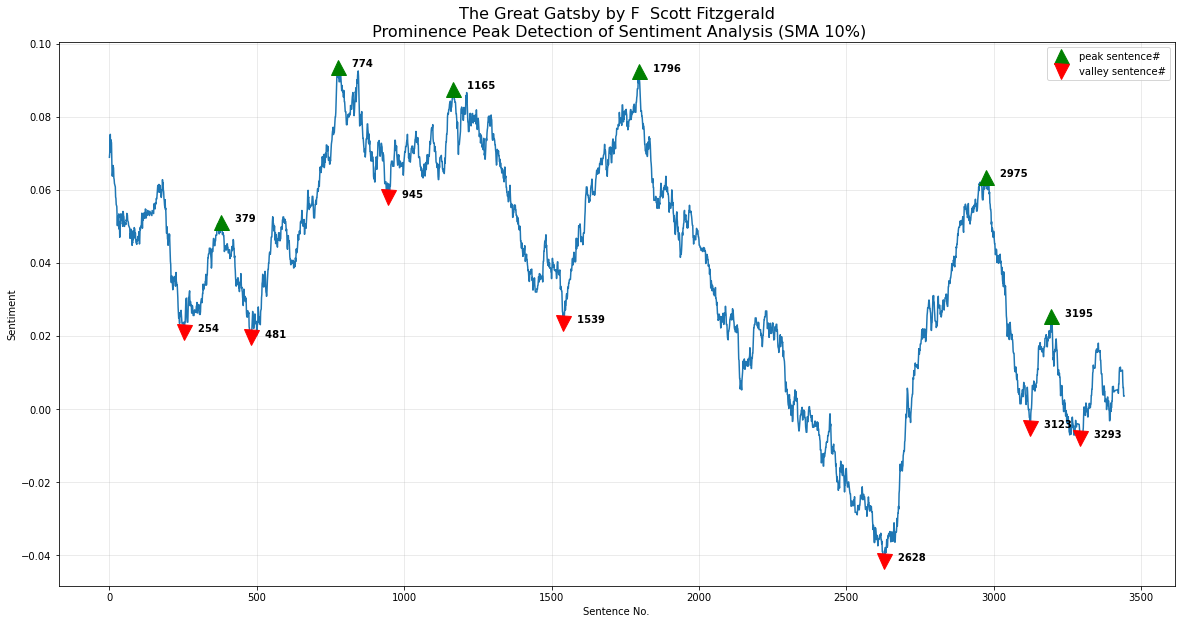



     >>>>> SAVED PLOT TO FILE: [cruxes_plot_The_Great_Gatsby_by_F__Scott_Fitzgerald.png] <<<<<


In [ ]:
#@title Select a Peak Detection Algorithms to View in Detail (usually Distance or Width is best):

plt.rcParams['figure.figsize'] = [20, 10]

Peak_Algorithm = "Prominence" #@param ["Distance", "Prominence", "Width", "Threshold"]

if Peak_Algorithm == 'Distance':
  peaks = peaks
  valleys = valleys
elif Peak_Algorithm == 'Prominence':
  peaks = peaks2
  valleys = valleys2  
elif Peak_Algorithm == 'Width':
  peaks = peaks3
  valleys = valleys3
else:
  # Assume Peak_Algorithm == 'Threshold'
  peaks = peaks4
  valleys = valleys4

# model_name = f'{Sentiment_Model.lower()}_sma10'

# x = novel_clean_df[model_name]

# peaks2, _ = find_peaks(x, prominence=peak_prominence)  

# x_inv = pd.Series([-x for x in novel_clean_df[model_name].to_list()])
# valleys2, _ = find_peaks(x_inv, prominence=peak_prominence)     

_ = plt.plot(x)
_ = plt.plot(peaks, x[peaks], "^g", markersize=15, label='peak sentence#')
_ = plt.plot(valleys, x[valleys], "vr", markersize=15, label='valley sentence#')
for x_val in peaks:
  _ = plt.text(x_val, x[x_val], f'    {x_val}', horizontalalignment='left', size='medium', color='black', weight='semibold')
for x_val in valleys:
  _ = plt.text(x_val, x[x_val], f'    {x_val}', horizontalalignment='left', size='medium', color='black', weight='semibold')
_ = plt.title(f'{Novel_Title}\n {Peak_Algorithm} Peak Detection of Sentiment Analysis (SMA {window_percent}%)', fontsize=16)
_ = plt.ylabel('Sentiment')
_ = plt.xlabel('Sentence No.')
_ = plt.legend(loc='best')
_ = plt.grid(True, alpha=0.3)

filename_plot = f"cruxes_plot_{Novel_Title.replace(' ', '_')}.png"
_ = plt.savefig(filename_plot, dpi=300)
_ = plt.show();

print(f'\n\n     >>>>> SAVED PLOT TO FILE: [{filename_plot}] <<<<<')

In [ ]:
# Download Crux Point Plot file 'crux_plot.png' to your laptop

files.download(filename_plot)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Get Context around Crux Points**

In [ ]:
#@title How many Sentences around Crux Point do you want to view for context?

Crux_Sentence_Context_Count = 19 #@param {type:"slider", min:1, max:20, step:1}


In [ ]:
# Print Context around each Sentiment Peak

output_ls = []

halfwin = int(Crux_Sentence_Context_Count/2)
crux_sents_ls = []
nl = '\n'

print('==================================================')
print('============     Peak Crux Points   ==============')
print('==================================================\n\n')

output_ls.append('==================================================')
output_ls.append('============     Peak Crux Points   ==============')
output_ls.append('==================================================\n\n')

# for i, apeak in enumerate(peaks2):
for i, apeak in enumerate(peaks):
  print(f'Processing Peak #{i}...')
  crux_sents_ls = []
  for sent_idx in range(apeak-halfwin,apeak+halfwin+1):
    sent_cur = sentiment_df.iloc[sent_idx].text_raw
    if sent_idx == apeak:
      sent_str = sent_cur.upper()
    else:
      sent_str = sent_cur
    crux_sents_ls.append(sent_str)
  
  # context_ls = sentiment_df.iloc[apeak-halfwin:apeak+halfwin].text_raw
  print(f"Peak #{i} at Sentence #{apeak}:\n\n{nl.join(crux_sents_ls)}\n\n\n")
  output_ls.append(f"Peak #{i} at Sentence #{apeak}:\n\n{nl.join(crux_sents_ls)}\n\n\n")

print('==================================================')
print('===========     Crux Valley Points    ============')
print('==================================================\n\n')

output_ls.append('==================================================')
output_ls.append('===========     Crux Valley Points    ============')
output_ls.append('==================================================\n\n')

# for i, avalley in enumerate(valleys2):
for i, avalley in enumerate(valleys):
  print(f'Processing Valley #{i}')
  crux_sents_ls = []
  for sent_idx in range(avalley-halfwin,avalley+halfwin+1):
    sent_cur = sentiment_df.iloc[sent_idx].text_raw
    if sent_idx == avalley:
      sent_str = sent_cur.upper()
    else:
      sent_str = sent_cur
    crux_sents_ls.append(sent_str)

  # context_ls = novel_df.iloc[avalley-halfwin:avalley+halfwin].text_raw
  print(f"Valley #{i} at Sentence #{avalley}:\n\n{nl.join(crux_sents_ls)}\n\n\n")
  output_ls.append(f"Valley #{i} at Sentence #{avalley}:\n\n{nl.join(crux_sents_ls)}\n\n\n")

filename_cruxes = f"cruxes_context_{Novel_Title.replace(' ', '_')}.txt" 

output_str = ' '.join(output_ls)

with open(filename_cruxes, 'w') as f:
    f.write(output_str)

============     Peak Crux Points   ==============


Processing Peak #0...
Peak #0 at Sentence #379:

"We're getting off!"
he insisted.
"I want you to meet my girl."
I think he'd tanked up a good deal at luncheon and his determination to
have my company bordered on violence.
The supercilious assumption was that
on Sunday afternoon I had nothing better to do.
I followed him over a low white-washed railroad fence and we walked
back a hundred yards along the road under Doctor Eckleburg's persistent
stare.
The only building in sight was a small block of yellow brick
sitting on the edge of the waste land, a sort of compact Main Street
ministering to it and contiguous to absolutely nothing.
One of the
three shops it contained was for rent and another was an all-night
restaurant approached by a trail of ashes; the third was a
garage--Repairs.
GEORGE B. WILSON.
CARS BOUGHT AND SOLD--AND I FOLLOWED
TOM INSIDE.
The interior was unprosperous and bare; the only car visible was the
dust-covered wre

20479

In [ ]:
# Download Crux Point Report file 'cruxes.txt' to your laptop

files.download(filename_cruxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cat $filename_cruxes

================================================== ============     Peak Crux Points   ============== ==================================================

 Peak #0 at Sentence #379:

"We're getting off!"
he insisted.
"I want you to meet my girl."
I think he'd tanked up a good deal at luncheon and his determination to
have my company bordered on violence.
The supercilious assumption was that
on Sunday afternoon I had nothing better to do.
I followed him over a low white-washed railroad fence and we walked
back a hundred yards along the road under Doctor Eckleburg's persistent
stare.
The only building in sight was a small block of yellow brick
sitting on the edge of the waste land, a sort of compact Main Street
ministering to it and contiguous to absolutely nothing.
One of the
three shops it contained was for rent and another was an all-night
restaurant approached by a trail of ashes; the third was a
garage--Repairs.
GEORGE B. WILSON.
CARS BOUGHT AND SOLD--AND I FOLLOWED
TOM INSIDE.
The i

# **END OF NOTEBOOK**